# Импорты

In [327]:
import numpy as np
import numpy.ma as ma
import scipy as sp
from functools import cmp_to_key
from utils import unique_2d

In [328]:
from numpy.linalg import det, inv, norm
from scipy.linalg import lu

In [329]:
import matplotlib.pyplot as plt
%matplotlib inline

# Выпуклая оболочка в $n$-мерном пространстве

Чтобы получить тройку, нам необходимо реализовать алгоритм quick hull в $n$-мерном пространстве.

Для начала, без ограничения общности, будем считать, что $n < m$, где $m$ - количество точек. Так как иначе, все точки принадлежат выпуклой оболочке.                           
Этот алгоритм легко обобщаем на произвольную размерность, поэтому, я сначала опишу его для двумерного случая.
Сначала, мы находим прямую (гиперплоскость) (она у нас будет назваться опорной) и разбиваем все оставшиеся точки на $2$ группы - выше нее и ниже нее.
Далее, в каждой группе мы делаем одно и то же с точностью до знака: находим самую высокую точку (это понятие будет введено позже), перебираем каждую точку на опорной прямой (гиперплоскости) и заменяем эту точку на "самую высокую",
и после замены запускаем алгоритм с новой опорной гиперплоскостью и новым множеством точек 
(тем, которое было попало в одну из групп).
Итак, описание алгоритма:

 1. находим опорную гиперплоскость $h$
 2. среди всех точек $p$ исходного множества, находим такую, что объем $p\cup h$ максимален.
 3. добавляем $p$ в ответ
 4. перебираем каждую точку в $h$ и заменяем ее на $p$. После замены переходим к пункту 2 для множества точек с положительными объемами и новой гиперплоскости. Если в новом множестве точек $< dim$, то переходим к пункту 5
 5. все

Разберемся поэтапно. На первом шаге, нам нужно найти опорную гиперплоскость. Это значит найти линейно независимый набор из $dim$ точек в исходном множестве. Это можно сделать с помощью метода Гаусса. Таким образом, если у нас точки лежат в массиве $A$, размера $(n, dim)$, то нам нужно просто применить метод Гаусса для матрицы $A$.
К сожалению, в библиотеках numpy и scipy нет функций для рассчета метода Гаусса напрямую. Но зато есть так называемая $LU$-декомпозиция.

## Определение

$LU$-декомпозиция матрицы $A$ - это разложение вида 
$$\large PA = LU$$
где $P$ - матрица размера $(n, n)$ из нулей и единиц, такая что в каждом столбце и в каждой строке только одна единица. Матрица $P$ отвечает за перестановку строк в матрице $A$. $L$ - нижнетреугольная матрица размера $(n, dim)$, $U$ - верхнетреугольная матрица размера $(dim, dim)$.
Размеры у матриц такие, потому что у нас $n > dim$. В общем случае там $(n, min(n, dim))$ и $(min(n, dim), dim)$ соответственно.

Про $LU$-декомпозицию нам необходимо знать то, что написано в определении, и то, что ранг матрицы $A$ равен рангу матрицы $U$.

Для начала докажем несколько вспомогательных утверждений:

## Утверждение

$$\large P^{-1} = P^T$$

### Доказательство

Рассмотрим два случая:
1. $i = j$. Тогда $i$-я строка в $P$ равна $j$-му столбцу в $P^T$. их произведение равно $1$.
2. $i \neq j$. Тогда соответствующие строка и столбец имеют единицы на разных позициях. Следовательно, их произведение равно нулю.

##  Утверждение

Если $rk U < dim$, то все точки лежат внутри одной гиперплоскости. Если $rk U = dim$, то первые $dim$ строк матрицы $PA$ линейно-независимы

### Доказательство

Пусть $rk U < dim$. $rk U = rk A$, следовательно, $rk A < dim$. Это значит, что любые dim строк в $A$ линейно-зависимы.

Пусть $rk U = dim$. Обозначим $A' = PA$, важно отметить, что $A'$ - это перестановка строк $A$.
Каждая строка $A'$ - это соответствующая строка из $L$, умноженная на $U$. Рассмотрим матрицу $L'$ - как первые $dim$ строк из $L$ и $A''$ - первые $dim$ строк из $A'$. Тогда $A'' = L' U$ - все матрицы квадратные.
Предположим, что $det(A'') = 0$. Тогда $det(A'') = det(L' U) = det(L') det(U)$, но $det(U) \neq 0$, так как $rk U = dim$, а $det(L') \neq 0$ по определению, поэтому $det(A'') \neq 0$.

## Теорема

Если $rk U = dim$, то первые $dim$ строк матрицы $PA$ принадлежат выпуклой оболочке $A$.

Для доказательства, вкратце опишем алгоритм вычисления $LU$-декомпозиции (пока не вводим матрицу $P$).


Пусть Дана матрица $A$, тогда рассмотрим первые строку и столбец матриц $A, L, U$:

$$A = 
\begin{bmatrix}
 a_{11}&A_{12} \\ 
 A_{21}&A_{22} 
\end{bmatrix}, \:
L = 
\begin{bmatrix}
 1&0 \\ 
 L_{21}&L_{22} 
\end{bmatrix}, \:
U = 
\begin{bmatrix}
 u_{11}&U_{12} \\ 
 0&U_{22} 
\end{bmatrix}$$

Где $a_{11}, u_{11}$ - числа, $A_{12}, A_{21}^T, L_{21}^T, U_{12}$ - 
матрицы-строки длины $dim - 1, n - 1, n - 1, dim -1$ соответственно.
$A_{22}, L_{22}, U_{22}$ - матрицы размера на 1 меньше чем исходные.
По определению,

$$
\begin{bmatrix}
 a_{11}&A_{12} \\ 
 A_{21}&A_{22} 
\end{bmatrix} = 
\begin{bmatrix}
 1&0 \\ 
 L_{21}&L_{22} 
\end{bmatrix} 
\begin{bmatrix}
 u_{11}&U_{12} \\ 
 0&U_{22} 
\end{bmatrix}
= 
\begin{bmatrix}
 u_{11}&U_{12} \\ 
 u_{11}L_{21}&L_{21}U_{12} + L_{22}U_{22} 
\end{bmatrix}
$$

Отсюда, получаем, что

$$
u_{11} = a_{11}, \:\: U_{12} = A_{12}, \:\: L_{21} = \frac{1}{a_{11}}A_{21}, \:\: 
A_{22} = L_{21}U_{12} + L_{22}U_{22}
$$

На $A_{22} - L_{21}U_{12} = L_{22}U_{22}$, можно смотреть как на LU-декомпозицию матриц размера на 1 меньше.

Очевидно, что если, $a_{11} = 0$, то алгоритм поломается. Для того, чтобы этого не происходило, нужна матрица $P$.
С помощью нее, в данном случае, на первое место будет поставлена любая строчка с ненулевым первым элементом. 
Имея такую свободу в выборе строки на каждом шаге, хотелось бы получить от нее наибольшую выгоду. Во всех стандартных реализациях PLU-декомпозиции на $i$-м шаге выбирается строка с максимальным по модулю $i$-м столбцом.

### Доказательство

Возьмем любую строку матрицы $A' = PA$. Пусть, она имеет номер $i$. Тогда у нее максимальная или минимальная $i$-я координата. Следовательно, все точки лежат либо левее, либо правее нее. Следовательно она принадлежит выпуклой оболочке.

После первого пункта следуют пункты, которые описывают главный цикл программы. Давайте рассмотрим их все сразу для удобства.

Определим функцию convex_sort, которая будет работать рекурсивно. Она будет принимать множество точек и гиперплоскость. Она будет делать непосредственно то, что описывалось ранее. Единственное, что есть несколько новых деталей реализации - будем передавать флаг side, отвечающий за то, какую мы оболочку сейчас считаем - верхнюю или нижнюю (side = 1 для верхней и -1 для нижней).

Теперь, у нас все готово для реализации первого пункта.

In [341]:
def quick_hull(points):
    """
    :param points набор точек, для которого необходимо посчитать выпуклую оболочку.
            должен иметь форму (n, dim), где dim - размерность пространства.
    """
    n, dim = points.shape
    convex_hull = np.array([]).reshape((-1, dim))
    # считаем LU-декомпозицию. В этой функции возвращаются матрицы p, l, u,
    # такие, что A = PLU. -> P^T A = LU
    p, l, u = lu(points, permute_l=False)
    # np.all(u == 0, axis=1) - пробегает по всем строкам u
    # и возвращает для каждой True если в ней одни нули.
    if np.any(np.all(np.abs(u) < 10e-8, axis=1)):
        # возвращаем исходный набор, так как он принадлежит одной плоскости
        return points
    hyperplane = p.T.dot(points)[:dim]
    convex_hull = np.vstack((convex_hull, hyperplane))
    # теперь все готово для рассчета выпуклой оболочки
    def convex_sort(point_set, hyperplane, side=1):
        nonlocal convex_hull, dim
        if len(point_set) < dim:
            return
        volumes = np.apply_along_axis(lambda x: vol(hyperplane, x), axis=1, arr=point_set) * side
        upper, = np.where(volumes > 10e-8)
        argmax = np.argmax(volumes)
        convex_hull = np.vstack((convex_hull, point_set[argmax]))
        for index, point in enumerate(hyperplane):
            point = np.array(point, copy=True)
            hyperplane[index] = point_set[argmax]
            convex_sort(point_set[upper], hyperplane, side=side)
            hyperplane[index] = point

    convex_sort(points, hyperplane, side=1)
    convex_sort(points, hyperplane, side=-1)
    
    return convex_hull[unique_2d(convex_hull)]

Проверим, как работает наша функция

In [344]:
def draw_2d_convex_hull(points, axis=None):
    convex_hull = quick_hull(points)
    # отсортируем точки по полярному углу, для этого ипользуем предикат поворота.
    # будем сортировать не сами точки а их номера.
    indices = range(len(convex_hull))
    def cmp(x, y):
        value = det(convex_hull[[x, y]] - convex_hull[0])
        if np.abs(value) < 10e-8:
            return 0
        return np.sign(value)
    indices = sorted(indices, key=cmp_to_key(cmp))
    #indices = [0] + indices
    indices += [indices[0]]
    # рисуем график
    if axis is None:
        plt.figure(figsize=(6,6))
        plt.scatter(points.T[0], points.T[1], c='r')
        plt.scatter(convex_hull[indices].T[0], convex_hull[indices].T[1], c='g')
        plt.plot(convex_hull[indices].T[0], convex_hull[indices].T[1], c='g')
        plt.title("Convex hull")
        plt.show()
    else:
        axis.scatter(points.T[0], points.T[1], c='r', s=10)
        axis.scatter(convex_hull[indices].T[0], convex_hull[indices].T[1], c='g')
        axis.plot(convex_hull[indices].T[0], convex_hull[indices].T[1], c='g')

Для заданного множества точек:

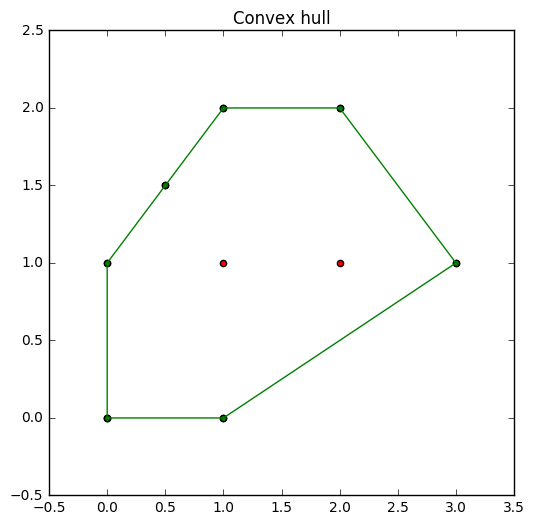

In [348]:
points = np.array([
       [0, 0],
       [1, 0],
       [2, 2],
       [3, 1],
       [0.5, 1.5],
       [0, 1],
       [1, 1],
       [1, 2],
       [2, 1]
])
draw_2d_convex_hull(points)

Для случайных точек:

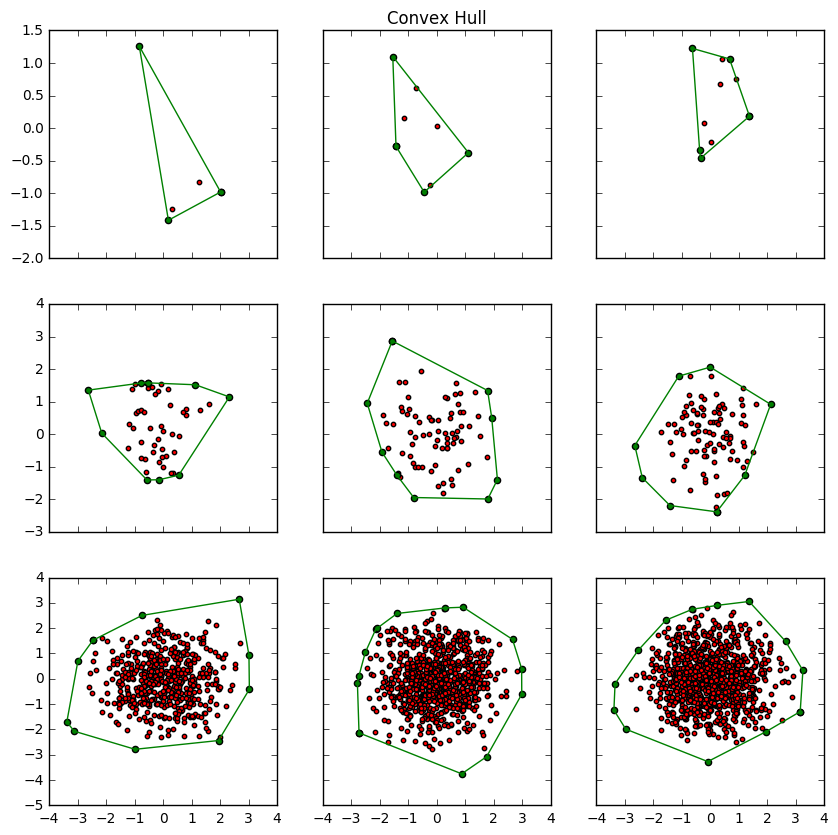

In [352]:
f, axes = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(10, 10))
for axes_row, count_row in zip(axes, [1, 10, 100]):
    for axis, count_col in zip(axes_row, [10, 16, 20]):
        points = np.random.normal(0., 1., count_row * count_col).reshape((int(count_row * count_col / 2), 2))
        draw_2d_convex_hull(points, axis=axis)
axes[0][1].set_title('Convex Hull')